In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# build the dataset
block_size = 3 #context size
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * 3
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(f'{"".join(itos[i] for i in context)} ----> {itos[ix]}')
        context = context[1:] + [ix] #update context

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [5]:
# Implementing Embedding matrix C (embedding lookup table: transforms characters/words into a vector)

C = torch.randn((27,2)) # in this example each context block is transformed into a 2D vector

emb = C[X] #embedding X

emb.shape #number of blocks, block size, nº of params/dimensions of the vector

torch.Size([32, 3, 2])

In [6]:
torch.cat(torch.unbind(emb, 1), 1).shape
#unbind separates gives list of tensors equivalent to [emb[:,0,:], emb[:,1,:], emb[:,2,:]]; we get all the parts of the context separatelly
#cat concatenates the three vectors and reduces the tensor dimension into 32*6 (instead of 32*3*2)
#this allows to perform matrix multiplication between emb and W1(the params of hidden layer that also have dim 32*6)
#inneficient

torch.Size([32, 6])

In [7]:
# equivalent to last cell
emb.view(-1,6).shape #transforms tensor shape into a 32*6 similarly to last cell but more efficiently and easier. -1 is equivalent to emb.shape[0] in this case

torch.Size([32, 6])

In [8]:
# Hidden Layer

W1 = torch.randn((6,100)) # initializing params: nº of inputs to the layer (context length * vector dim (3*2 = 6), nº of neurons in the hidden layer hyperparameter (100))
b1 = torch.randn(100) # biases for hidden layer

h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # gives activations of hidden layer
h.shape
 

torch.Size([32, 100])

In [9]:
#Out Layer

W2 = torch.randn((100,27))
b2 = torch.randn(27) #number of character

logits = h @ W2 +b2

counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [10]:
prob.shape

torch.Size([32, 27])

In [11]:
loss = - prob[torch.arange(32), Y].log().mean() #neg log likelihood loss
loss


tensor(19.2605)

Re-organizing the code

In [12]:
# Dataset
# build the dataset
block_size = 3 #context size
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] #update context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [13]:
#Initializing parameters

g = torch.Generator().manual_seed(2147483647) #seed
C = torch.randn((27,2), generator = g) # embedding matrix

#hidden layer
W1 = torch.randn((6,100), generator = g) 
b1 = torch.randn(100, generator = g)

#out layer
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)

#Parameters
parameters = [C, W1, b1, W2, b2]

In [14]:
sum(p.nelement() for p in parameters) #tot number of params

3481

In [15]:
for p in parameters:
    p.requires_grad = True

Training the NN

In [24]:
#Training the NN. Using mini-batch grad descent.

for i in range(10000):

    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) #selects 32 random elements of the dataset.

    #forward pass
    emb = C[X[ix]] #embedding minibatch

    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #activations of hidden layer

    logits = h @ W2 + b2
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim = True) #getting out probabilities
    #loss = - prob[torch.arange(32), Y].log().mean() #neg log likelihood loss 
    loss = F.cross_entropy(logits, Y[ix]) #built-in PyTorch. Optimized/ much more efficient. Much easier backward pass. More numerically "well-behaved" (handling of extreme values).
    print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None #setting grad to 0

    loss.backward()

    #update parameters
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad 

#print(loss.item())

2.31027889251709
2.2187297344207764
2.1702420711517334
2.3700034618377686
2.2416024208068848
1.992945671081543
2.598177194595337
2.170447826385498
2.079990863800049
2.1074540615081787
2.136800765991211
2.2409608364105225
2.109315872192383
2.282557487487793
2.3146910667419434
2.3976521492004395
2.3332858085632324
2.4463491439819336
2.491523265838623
2.1389079093933105
2.6095495223999023
2.481463670730591
2.326406478881836
2.4003255367279053
2.145658493041992
2.513068675994873
2.1183066368103027
2.3104569911956787
2.081423759460449
2.110342264175415
2.3488996028900146
2.161897897720337
2.4190776348114014
2.261406660079956
2.416677951812744
2.068037986755371
2.730430841445923
2.9046812057495117
2.6249990463256836
2.359272003173828
2.6270697116851807
2.85476016998291
2.7140886783599854
2.323188543319702
2.0475752353668213
2.1412744522094727
2.3459925651550293
2.4347872734069824
2.6094298362731934
2.265486717224121
2.50517201423645
2.145986318588257
2.5019803047180176
2.551234245300293
2.54

2.142298936843872
2.272057056427002
2.525862216949463
2.4174373149871826
2.5159950256347656
2.3000450134277344
1.9170619249343872
2.4589197635650635
2.315056562423706
2.48351788520813
2.4807586669921875
2.286715507507324
2.4185917377471924
2.4728269577026367
2.5536608695983887
2.2930262088775635
2.463038682937622
1.9407743215560913
2.104079246520996
2.4204821586608887
2.6784279346466064
2.1853156089782715
2.2411727905273438
2.1861183643341064
1.9444533586502075
2.6812121868133545
2.449324369430542
2.2515602111816406
2.5598814487457275
2.311229705810547
2.641951560974121
2.239557981491089
2.4609243869781494
2.5057902336120605
2.184016704559326
2.4571657180786133
2.4831223487854004
2.1665005683898926
2.775435447692871
2.4872710704803467
2.1317598819732666
2.05820369720459
2.1933414936065674
2.3096909523010254
1.9801582098007202
2.3030123710632324
2.0787596702575684
2.309230089187622
2.0163867473602295
2.4739716053009033
2.4234228134155273
2.4860219955444336
2.429410457611084
2.7249689102

In [25]:
#Now check loss for full dataset (not minibatch)
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss
#loss ~= 2.30

tensor(2.3029, grad_fn=<NllLossBackward0>)

Tuning learning rate

In [16]:
lre = torch.linspace(-3, 0, 1000) 
lrs = 10**lre #setting lr to different values (between 0.001 and 1) to be able to optimize

In [17]:
#Training the NN. Using mini-batch grad descent. Tuning learning rate.

lri = []
lossi = []

for i in range(1000):

    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) #selects 32 random elements of the dataset.

    #forward pass
    emb = C[X[ix]] #embedding minibatch

    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #activations of hidden layer

    logits = h @ W2 + b2
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim = True) #getting out probabilities
    #loss = - prob[torch.arange(32), Y].log().mean() #neg log likelihood loss 
    loss = F.cross_entropy(logits, Y[ix]) #built-in PyTorch. Optimized/ much more efficient. Much easier backward pass. More numerically "well-behaved" (handling of extreme values).
    print(loss.item())

    #backward pass
    for p in parameters:
        p.grad = None #setting grad to 0

    loss.backward()

    #update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad 

    #track stats
    lri.append(lre[i])
    lossi.append(loss.item())

#print(loss.item())

19.92198371887207
20.43973159790039
21.75568962097168
19.16636848449707
21.29129409790039
18.539512634277344
20.940832138061523
20.43671989440918
21.476560592651367
17.299339294433594
18.719449996948242
19.113283157348633
21.898630142211914
18.48836326599121
18.717191696166992
16.20254898071289
20.98377227783203
20.35228729248047
18.661413192749023
18.876811981201172
21.22170066833496
19.644390106201172
19.894771575927734
21.360414505004883
17.996074676513672
19.6802978515625
17.971206665039062
23.101659774780273
19.978900909423828
16.362224578857422
19.272737503051758
17.974096298217773
17.271137237548828
17.065370559692383
17.794109344482422
16.460880279541016
20.85593032836914
17.420900344848633
22.66915512084961
18.373682022094727
18.71718978881836
17.37886619567871
17.529766082763672
18.124536514282227
20.163198471069336
18.057598114013672
16.514110565185547
20.565467834472656
22.299457550048828
15.371329307556152
17.15251922607422
18.45522689819336
18.343965530395508
17.301692962

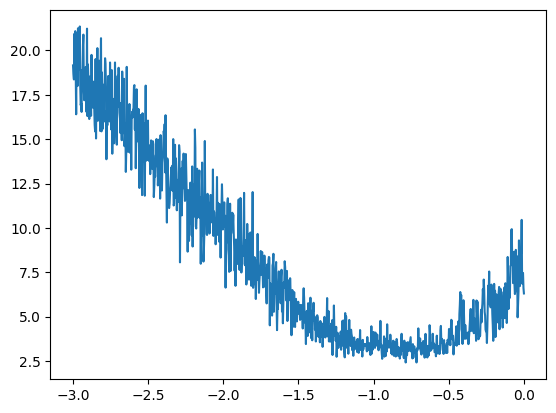

In [29]:
#finding optimal learning rate
plt.plot(lri, lossi)

In [26]:
#From this we can conclude that 0.1 is a good lr rate

Splitting the data

In [7]:
#training split (train parameters), dev/validation split (train hyperparameters), test split (evaluate)
# 80%, 10%, 10%
# avoids overfitting
 
#build the dataset

def build_dataset(words):
    block_size = 3 #context size
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #update context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
#Initializing parameters
g = torch.Generator().manual_seed(2147483647) #seed
C = torch.randn((27,10), generator = g) # embedding matrix #we try higher dimensional embeddings

#hidden layer
W1 = torch.randn((30,200), generator = g)  #trying a larger hidden layer
b1 = torch.randn(200, generator = g)

#out layer
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)

#Parameters
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) #tot number of params

11897

In [9]:
lossi = []
stepi = []
#training params
for i in range(200000):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) #selects 32 random elements of the dataset.

    #forward pass
    emb = C[Xtr[ix]] #embedding minibatch
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #activations of hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) #built-in PyTorch. Optimized/ much more efficient. Much easier backward pass. More numerically "well-behaved" (handling of extreme values).

    #backward pass
    for p in parameters:
        p.grad = None #setting grad to 0
    loss.backward()

    #update parameters
    lr = 0.1 if i < 100000 else 0.01 #adjusting lr
    for p in parameters:
        p.data += -lr * p.grad 

    #track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

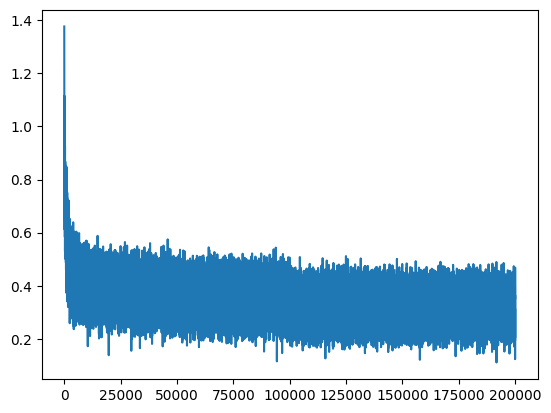

In [10]:
#Visualizing loss
plt.plot(stepi, lossi)

In [12]:
# evaluate with training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #activations of hidden layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1234, grad_fn=<NllLossBackward0>)

In [13]:
# evaluating with validation set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) #activations of hidden layer
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1631, grad_fn=<NllLossBackward0>)

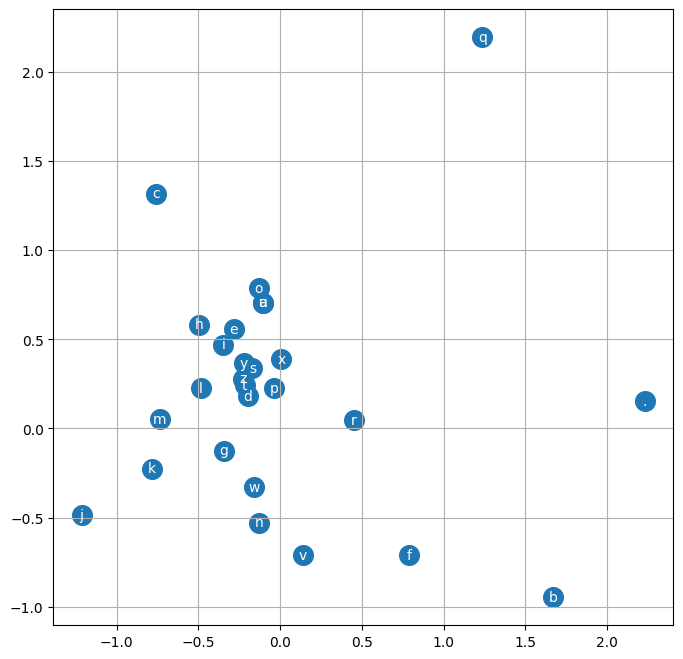

In [14]:
#Visualizing embeddings after training
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [61]:
#we can see all vowels are aggruped. a,e,i,o,u,y 
# "." is very isolated indicating its special character...
#Visualized for 2D embedding

Sampling from the model

In [22]:
def generate_names():
    block_size = 3
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] #(1, block_size, dim of embedding)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator = g).item() #samples from prob distribution
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            return (''.join(itos[i] for i in out))


        


In [26]:
for _ in range(20):
    print(generate_names()) 

shaban.
yostine.
wemetristina.
kamyer.
tan.
samil.
malaislyn.
akabjurailynn.
saui.
korratee.
tozia.
variya.
jayel.
anne.
joagaylyse.
myan.
tal.
gayannite.
tairon.
tyri.
